In [2]:
import numpy as np
import random
import sys
import io
import os
import glob
import IPython
import matplotlib.pyplot as plt
import librosa
import librosa.display

from keras.models import load_model

Using TensorFlow backend.


In [16]:
# 画出语谱图 从图中我们其实可以看出来，针对语谱图进行DNN建模会比在时域建模更有效
def show_wav_spect(wav_path):
    data_,_=librosa.load(wav_path,16000)
    fdata_=librosa.stft(data_,n_fft=1024,hop_length=512,win_length=1024,window='hann')
    #print(type(fdata_))
    abdata_=np.abs(fdata_)
    #dbdata_=librosa.amplitude_to_db(abdata_,ref=np.max)
    #librosa.display.specshow(dbdata_,sr=16000,y_axis='linear')
    #plt.colorbar(format='%+2.0f dB')
    #plt.title('Linear-frequency power spectrogram')
    return abdata_
    
abdata=show_wav_spect("./data/background/bg_01.wav")
# 能够借此看出来，我们的时间步长为313，每个步长上的频谱为513个
print(abdata.shape)
n_freq=513
Tx=313
Ty=125

(513, 313)


In [17]:
# 由于语音不好打标签，我们采用背景噪声+唤醒词+非唤醒词这种组合来拼凑带标签数据
# 比如一个10s的背景噪声与一个2s的唤醒词组合得到一个10s的组合声音
# 我们这里定义四个函数来完成数据的准备工作：
# get_random_insert_pos(data_)
# is_overlapping(existing_segments, pos)
# insert_audio_clip(background, audio_clip, existing_segments)
# insert_ones(y, segment_end_pos)
# 同时我还需要增加一个自己版本的overlay,用于合并音频
# overlay(bg,ac,pos)

# 合并音频
def overlay(bg,ac,pos):
    start_pos,end_pos=pos
    tmp=np.zeros(len(bg))
    tmp[start_pos:end_pos+1]=ac
    combine=(tmp+bg)/2
    return combine


In [18]:
# 获取随机插入位置，不过不应该超过数据总长度-数据长度的位置
def get_random_insert_pos(data_,to_insert_len):
    #start_pos,end_pos=pos
    #to_insert_len=end_pos-start_pos
    pos=np.random.randint(0,len(data_)-1-to_insert_len)
    return (pos,pos+to_insert_len-1)

In [19]:
# 判断是否有重叠，最大的开始端 <  最小的结束端点
def is_overlapping(existing_segments,pos):
    start_pos,end_pos=pos
    for e_start_pos,e_end_pos in existing_segments:
            if max(e_start_pos,start_pos) < min(end_pos,e_end_pos):
                return False
    return True       

In [20]:
# 插入音频
def insert_audio_clip(background,audio_clip,existing_segments):
    # 随机找到一个插入位置
    pos=get_random_insert_pos(background,len(audio_clip))
    #print(len(audio_clip))
    #print(pos[1]-pos[0])
    # 判断需要插入的位置是否已经插入了别的音频 各个段之间是否会有交叉
    while(is_overlapping(existing_segments,pos)):
        existing_segments.append(pos)
    background=overlay(background,audio_clip,pos)
    return background,existing_segments

In [21]:
# 主要用来生成标签
# 之所以这里有个50是因为我们认为50个时间段内，算法监测到唤醒词终点我们都认为是可以接受的
def insert_ones(y,segments_end_pos):
    segments_end_pos=int(segments_end_pos*Ty/160000)
    label=np.zeros(len(y))
    for ep in range(segments_end_pos,segments_end_pos+51):
        if(ep<len(y)):
            label[ep]=1
        else:
            return label
    return label

In [22]:
def get_train_example():
    ac="./data/activate"
    bg="./data/background"
    ne="./data/negative"
    fs=16000
    num_examples=100
    X_train=np.zeros((num_examples,n_freq,Tx))
    Y_train=np.zeros((num_examples,Ty,1))

    # 我们生成10条训练数据
    for i in range(0,num_examples):
        file_name="./data/train_example/"+str(i)+".wav"
        audio_clip_file=ac+"/hot_0"+str(random.randint(1,4))+".wav"
        ne_clip_file=ne+"/ne_0"+str(random.randint(1,3))+".wav"
        bg_file=bg+"/bg_0"+str(random.randint(1,2))+".wav"
        
        fs=16000
        audio_clip,_=librosa.load(audio_clip_file,fs)
        ne_clip,_=librosa.load(ne_clip_file,fs)
        background,_=librosa.load(bg_file,fs)
        
        
        existing_segments=list()
        if i%2==0:
            train_example,existing_segments=insert_audio_clip(background,audio_clip,existing_segments)
            for s,e in existing_segments:
                Y_train[i,:,0]=insert_ones(Y_train[i,:,0],e)   
            
        train_example,_=insert_audio_clip(train_example,ne_clip,existing_segments)
        librosa.output.write_wav(file_name,train_example,fs)
        X_train[i,:,:]=show_wav_spect(file_name)
        
    return X_train,Y_train
        
X_train,Y_train=get_train_example()

In [23]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [24]:
def model(input_shape):
    X_input=Input(input_shape)
     # Step 1: CONV layer (≈4 lines)
    X = Conv1D(196, 15, strides=4)(X_input)                    # CONV1D
    X = BatchNormalization()(X)                                # Batch normalization
    X = Activation('relu')(X)                                  # ReLu activation
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [25]:
model = model(input_shape = (n_freq, Tx))

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 513, 313)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 125, 196)          920416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 196)          784       
_________________________________________________________________
activation_1 (Activation)    (None, 125, 196)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 196)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 125, 128)          124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 125, 128)          0         
__________

In [27]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [28]:
#model.fit(X_train, Y_train, batch_size = 5, epochs=1)
print(X_train.shape)
print(Y_train.shape)

(100, 513, 313)
(100, 125, 1)


In [29]:
model.fit(X_train, Y_train, batch_size =5, epochs=300)

Epoch 1/300
100/100 [==============================] - 6s 58ms/step - loss: 1.1994 - acc: 0.5260
Epoch 2/300
100/100 [==============================] - 4s 38ms/step - loss: 1.0358 - acc: 0.5494
Epoch 3/300
100/100 [==============================] - 4s 38ms/step - loss: 0.9285 - acc: 0.5720
Epoch 4/300
100/100 [==============================] - 4s 38ms/step - loss: 0.8548 - acc: 0.5906
Epoch 5/300
100/100 [==============================] - 4s 39ms/step - loss: 0.7842 - acc: 0.6167
Epoch 6/300
100/100 [==============================] - 4s 40ms/step - loss: 0.7581 - acc: 0.6246
Epoch 7/300
100/100 [==============================] - 4s 42ms/step - loss: 0.6977 - acc: 0.6514
Epoch 8/300
100/100 [==============================] - 4s 41ms/step - loss: 0.6785 - acc: 0.6590
Epoch 9/300
100/100 [==============================] - 4s 41ms/step - loss: 0.6600 - acc: 0.6674
Epoch 10/300
100/100 [==============================] - 4s 41ms/step - loss: 0.6226 - acc: 0.6942
Epoch 11/300
100/100 [=======

KeyboardInterrupt: 

In [3]:
#model.save("./models/300_epoch.h5")
model=load_model("./models/300_epoch.h5")
X_dev = np.load("./data/dev/X_dev.npy")
Y_dev = np.load("./data/dev/Y_dev.npy")

FileNotFoundError: [Errno 2] No such file or directory: './data/dev/X_dev.npy'

In [34]:
print(X_dev.shape)
print(Y_dev.shape)

(100, 513, 313)
(100, 125, 1)


In [35]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

100/100 [==============================] - 0s 4ms/step
Dev set accuracy =  0.8068000078201294


In [4]:
def detect_triggerword(filename,threshold):
    plt.subplot(2, 1, 1)

    x = show_wav_spect(filename)
    x_=librosa.amplitude_to_db(x,ref=np.max)
    librosa.display.specshow(x_,sr=16000,y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Linear-frequency power spectrogram')
    
    #x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    print(predictions.shape)
    print(predictions[0,:,0])
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 50:
            # Step 5: Superpose audio and background using pydub
            print("小朗浪起来～")
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
            return
    
    return predictions

(1, 125, 1)
[1.9943453e-02 3.5728035e-03 9.1346412e-04 3.4978974e-04 1.9691016e-04
 1.5204216e-04 1.4215276e-04 1.0851430e-04 9.4534887e-05 8.4551670e-05
 8.1687016e-05 7.5534626e-05 7.3954274e-05 6.4954664e-05 6.5780594e-05
 6.1506384e-05 6.0829174e-05 6.5417022e-05 6.6599627e-05 7.2492032e-05
 8.9995709e-05 1.2048753e-04 1.8167429e-04 3.1410088e-04 5.4197235e-04
 8.5483625e-04 1.2541758e-03 1.7747900e-03 2.5034810e-03 3.5953734e-03
 5.1081744e-03 6.9267182e-03 9.3092658e-03 1.2930103e-02 1.8637067e-02
 2.8082240e-02 4.6069797e-02 8.1230640e-02 1.5270175e-01 2.9388404e-01
 5.1761752e-01 7.5425589e-01 9.0585065e-01 9.6883047e-01 9.8925120e-01
 9.9561441e-01 9.9778807e-01 9.9860954e-01 9.9896502e-01 9.9913162e-01
 9.9921012e-01 9.9923837e-01 9.9924266e-01 9.9923706e-01 9.9923193e-01
 9.9922669e-01 9.9922967e-01 9.9923670e-01 9.9925274e-01 9.9927038e-01
 9.9931395e-01 9.9937648e-01 9.9943072e-01 9.9947220e-01 9.9949586e-01
 9.9950242e-01 9.9950099e-01 9.9949098e-01 9.9947363e-01 9.994472

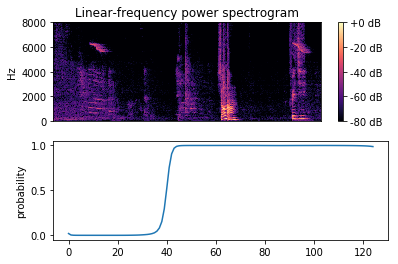

小朗浪起来～


In [15]:
filename = "./data/dev/0.wav"
prediction = detect_triggerword(filename,0.6)

#IPython.display.Audio("./chime_output.wav")